In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/housing-price-prediction-data/housing_price_dataset.csv


In [6]:
df = pd.read_csv('/kaggle/input/housing-price-prediction-data/housing_price_dataset.csv')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   SquareFeet    50000 non-null  int64  
 1   Bedrooms      50000 non-null  int64  
 2   Bathrooms     50000 non-null  int64  
 3   Neighborhood  50000 non-null  object 
 4   YearBuilt     50000 non-null  int64  
 5   Price         50000 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 2.3+ MB


In [8]:
df.describe(include='all')

,SquareFeet,Bedrooms,Bathrooms,Neighborhood,YearBuilt,Price
count,50000.000000,50000.000000,50000.000000,50000,50000.000000,50000.000000
unique,NaN,NaN,NaN,3,NaN,NaN
top,NaN,NaN,NaN,Suburb,NaN,NaN
freq,NaN,NaN,NaN,16721,NaN,NaN
mean,2006.374680,3.498700,1.995420,NaN,1985.404420,224827.325151
std,575.513241,1.116326,0.815851,NaN,20.719377,76141.842966
min,1000.000000,2.000000,1.000000,NaN,1950.000000,-36588.165397
25%,1513.000000,3.000000,1.000000,NaN,1967.000000,169955.860225
50%,2007.000000,3.000000,2.000000,NaN,1985.000000,225052.141166
75%,2506.000000,4.000000,3.000000,NaN,2003.000000,279373.630052


Only thing that stands out is the negative minimum in the Price column; could indicate a refund.

<Axes: xlabel='Neighborhood', ylabel='count'>

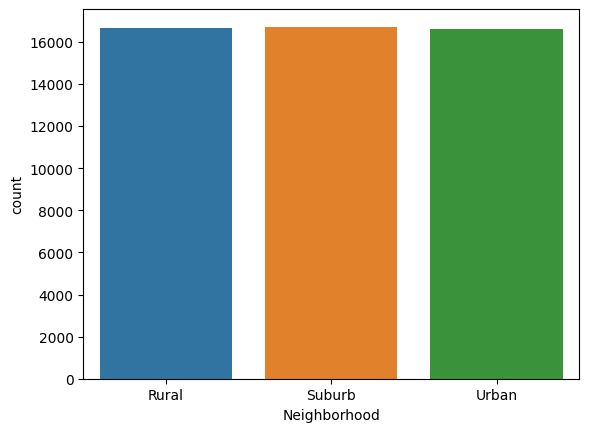

In [9]:
sns.countplot(x=df.Neighborhood)

Seeming evenly distributed neighborhoods.

In [10]:
df.Neighborhood.value_counts(dropna=False)

Neighborhood
Suburb    16721
Rural     16676
Urban     16603
Name: count, dtype: int64

Segmenting by Neighborhood.

In [11]:
suburb = df[df.Neighborhood=='Suburb'].drop(columns=['Neighborhood'])
rural= df[df.Neighborhood=='Rural'].drop(columns=['Neighborhood'])
urban = df[df.Neighborhood=='Urban'].drop(columns=['Neighborhood'])


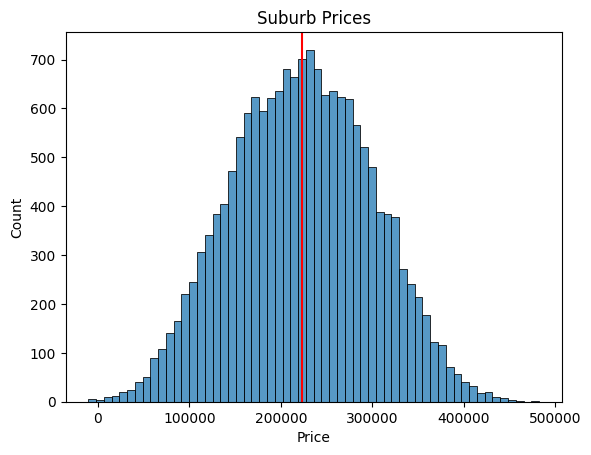

In [12]:
sns.histplot(suburb.Price)
plt.title('Suburb Prices')
plt.axvline(suburb.Price.mean(), color='red')

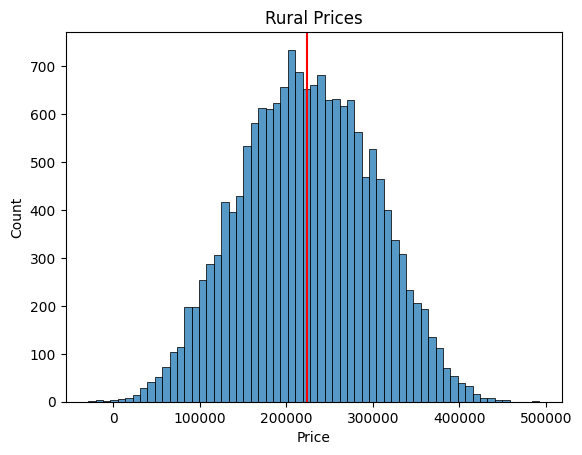

In [13]:
sns.histplot(rural.Price)
plt.title('Rural Prices')
plt.axvline(rural.Price.mean(), color='red')

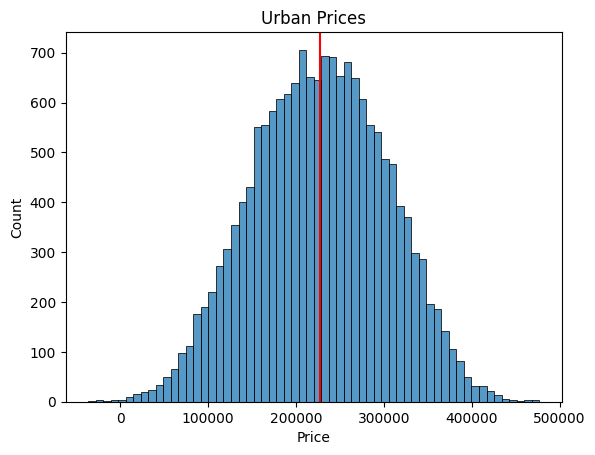

In [14]:
sns.histplot(urban.Price)
plt.title('Urban Prices')
plt.axvline(urban.Price.mean(), color='red')

Prices in all segments/neighborhoods are normally distributed; according to the sample

In [15]:
from scipy.stats import f_oneway

In [16]:
f_stat, pval = f_oneway(suburb.Price, rural.Price,urban.Price)

if pval<0.05:
    print('There is a significant statistical difference between atleast one pairing')
else:
    print('There is no statistical difference.')

There is a significant statistical difference between atleast one pairing


Using the Tukey test to get the actual pairings with signs of statistical difference.

In [17]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [20]:
result = pairwise_tukeyhsd(df.Price,df.Neighborhood)
print(result)

   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
group1 group2  meandiff p-adj    lower      upper   reject
----------------------------------------------------------
 Rural Suburb -861.9362  0.555 -2814.5542 1090.6818  False
 Rural  Urban 3070.0711 0.0007  1113.9915 5026.1507   True
Suburb  Urban 3932.0073    0.0  1977.2413 5886.7733   True
----------------------------------------------------------


There is a difference in prices in Rural and Urban neighborhoods.
There is a difference in prices in Suburb and Urban neighborhoods.
These differences aren't random.

When writing a model to predit prices, segment data into two; rural and urbal, suburb and urban. this is done to get a decent model.
But how good will the model be without segmenting in this manner?

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [31]:
df.columns

Index(['SquareFeet', 'Bedrooms', 'Bathrooms', 'Neighborhood', 'YearBuilt',
       'Price'],
      dtype='object')

In [41]:
df.Neighborhood.value_counts()

Neighborhood
Suburb    16721
Rural     16676
Urban     16603
Name: count, dtype: int64

In [57]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder
df =pd.get_dummies(data=df,columns=['Neighborhood'])

In [58]:
df.head()

,SquareFeet,Bedrooms,Bathrooms,YearBuilt,Price,Neighborhood_Rural,Neighborhood_Urban,Neighborhood_Suburb
0,2126,4,1,1969,215355.283618,True,False,False
1,2459,3,2,1980,195014.221626,True,False,False
2,1860,2,1,1970,306891.012076,False,False,True
3,2294,2,1,1996,206786.787153,False,True,False
4,2130,5,2,2001,272436.239065,False,False,True


In [60]:
features = df.drop(columns='Price')

In [61]:
linear_model = LinearRegression()
X_train,X_test,Y_train,Y_test = train_test_split(features,df['Price'],test_size=0.25,random_state=40)

In [62]:
linear_model.fit(X_train,Y_train)
ypred = linear_model.predict(X_test)

In [63]:
from sklearn.metrics import  mean_squared_error, r2_score

mse = mean_squared_error(Y_test,ypred)
print('The mean squared error is ',mse)

r2_sco = r2_score(Y_test,ypred)
print('The r2 score is ',r2_sco)

The mean squared error is  2471569746.093699
The r2 score is  0.5790577168470001


The R2 score of approximately 0.58 means that the model explains around 58% of the variance in housing prices.
While an R2 score of 1 would indicate a perfect fit, achieving very high R2 scores in real-world housing price predictions can be challenging due to the numerous factors influencing home values.